In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise2 import compute_stft, plot_spectrum
from utils.code_exercise3 import get_a_vector, get_b0, inspect_segment_lpc
from scipy.signal import get_window, lfilter, freqz
import sounddevice

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
a = np.loadtxt("data/exercise5/filter-data.txt")

In [3]:
a

array([ 1.        , -0.5154163 , -0.02289864, -0.92057969, -0.13097223,
        0.23450348,  0.7963136 ,  0.20497006,  0.1388989 , -0.53052396,
       -0.04920074, -0.12051398,  0.05875205,  0.07278386,  0.06344769,
        0.02236939])

In [4]:
a.shape

(16,)

In [5]:
fs = 16000
frame_length = 32
n_samples = fs * frame_length // 1000
hann_win = get_window('hann', n_samples)

In [6]:
u = np.zeros(n_samples)

In [7]:
u[::100] = 1

In [8]:
s = lfilter(np.array([1]), a, u)
freq, H = freqz(1, a, 257)

In [9]:
sw = s * hann_win
uw = u * hann_win

In [10]:
def get_cepstrum(s):
    spectra = np.fft.rfft(s) + np.finfo(np.float64).eps
    log_spectra = np.log(spectra)
    cepstrum = np.fft.ifft(log_spectra)
    return cepstrum, log_spectra

In [11]:
cs, _ = get_cepstrum(s)
cu, _ = get_cepstrum(u)
ch, _ = get_cepstrum(H)

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


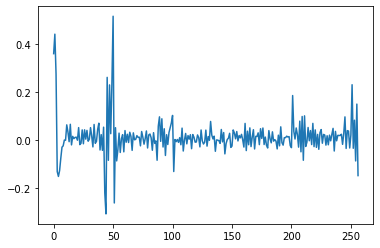

In [12]:
plt.plot(cs)

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


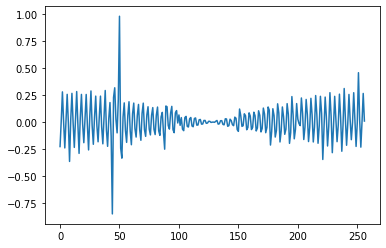

In [13]:
plt.plot(cu)

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


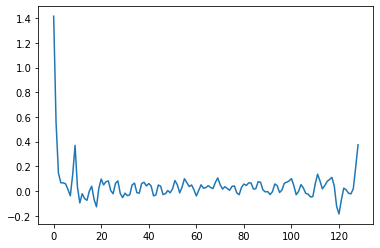

In [14]:
plt.plot(ch)

In [15]:
temp = np.copy(cs)

In [16]:
temp[0] = -np.inf

In [17]:
np.argmax(temp)

50

In [18]:
def reconstruct_filter_and_source(cepstrum, fs, L):
    cutoff = int(fs * L / 1000 / 2)

    cept_trunc_h = np.zeros(cepstrum.shape[0])
    cept_trunc_h[:cutoff] = 1
    cept_trunc_u = np.zeros(cepstrum.shape[0])
    cept_trunc_u[cutoff:] = 1
    ch = cepstrum * cept_trunc_h
    cu = cepstrum * cept_trunc_u
    
    H_est = np.fft.fft(ch)
    U_est = np.fft.fft(cu)
    return H_est, U_est

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

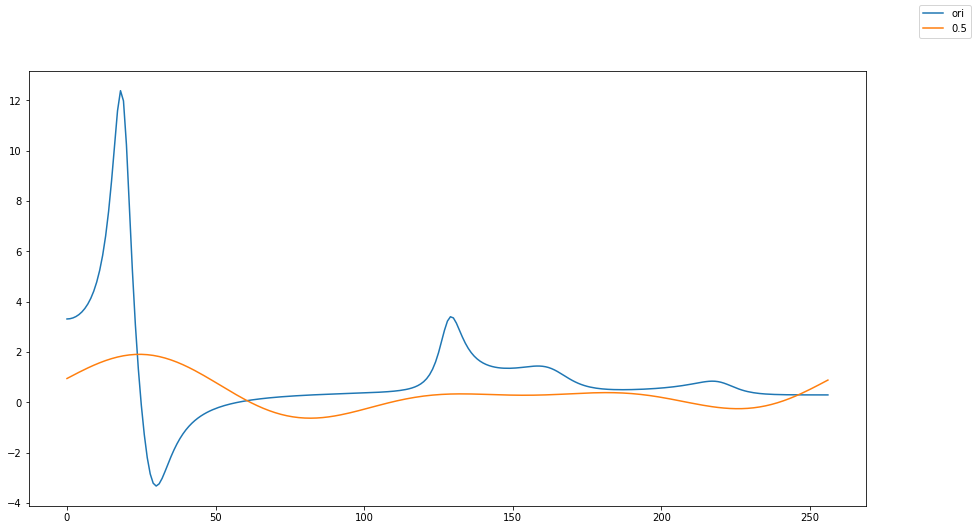

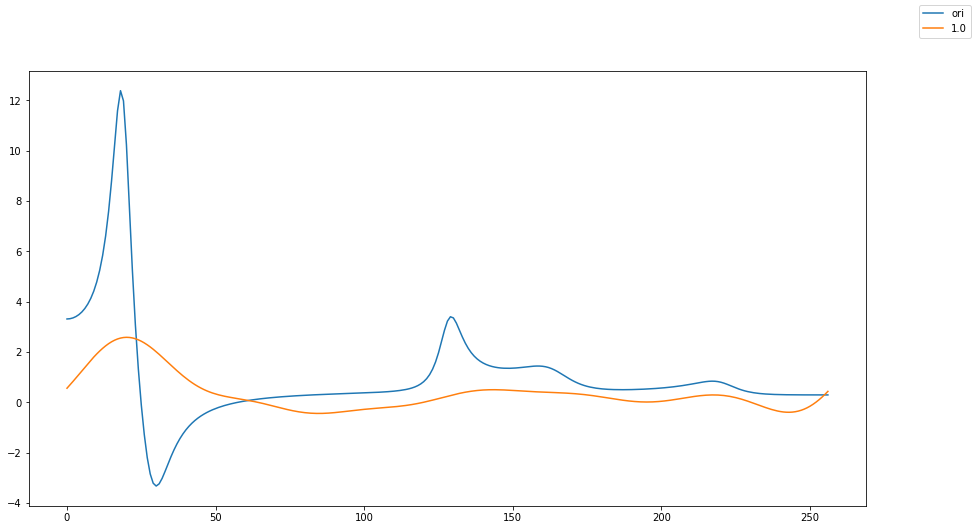

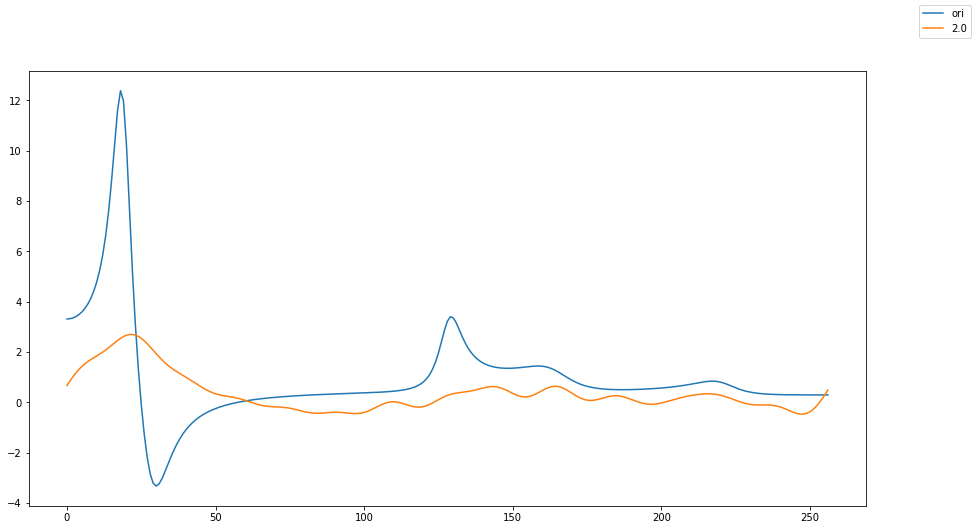

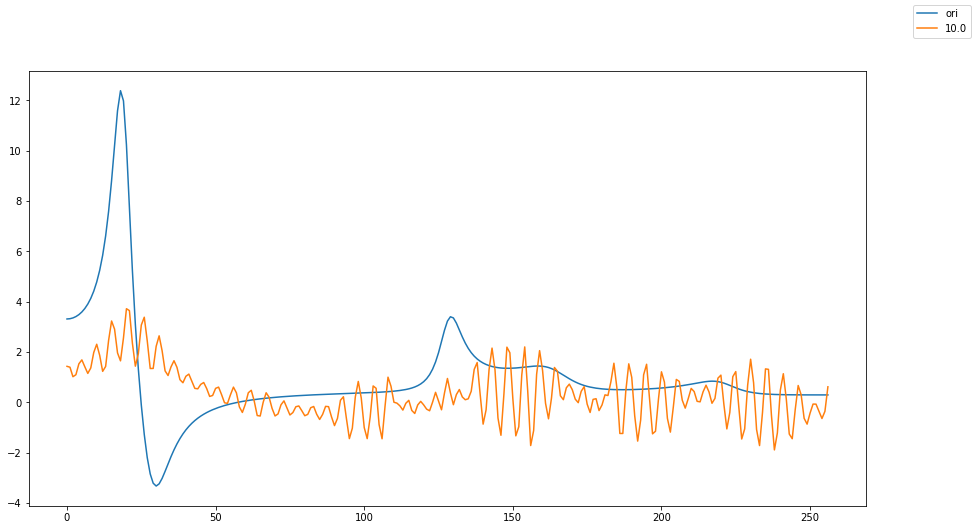

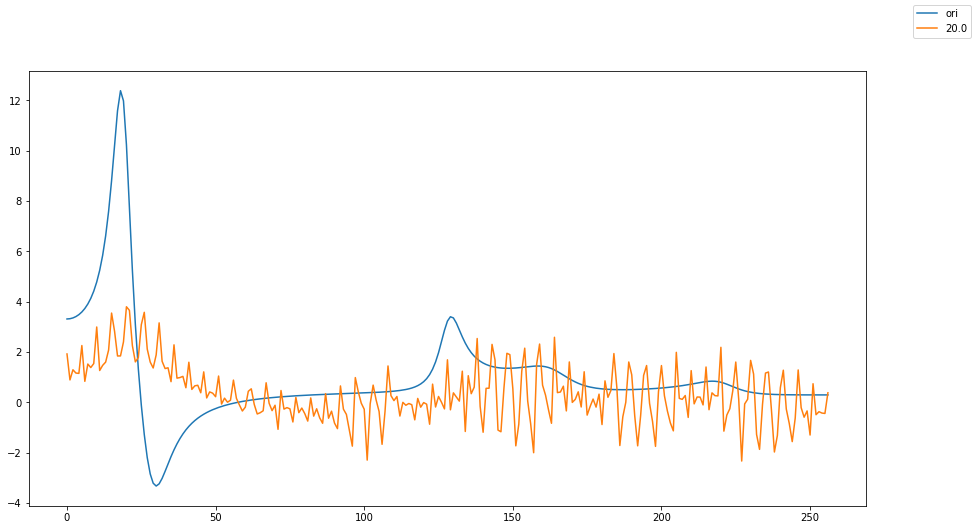

In [19]:
for L in [0.5,1.,2.,10.,20.]:
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    
    H_est, U_est = reconstruct_filter_and_source(cs, fs, L)
    ax.plot(H, label="ori")
    ax.plot(H_est, label=L)
    fig.legend()

In [49]:
y, sr = librosa.core.load("data/exercise5/speech1.wav", sr=None)

In [50]:
sounddevice.play(y, sr)

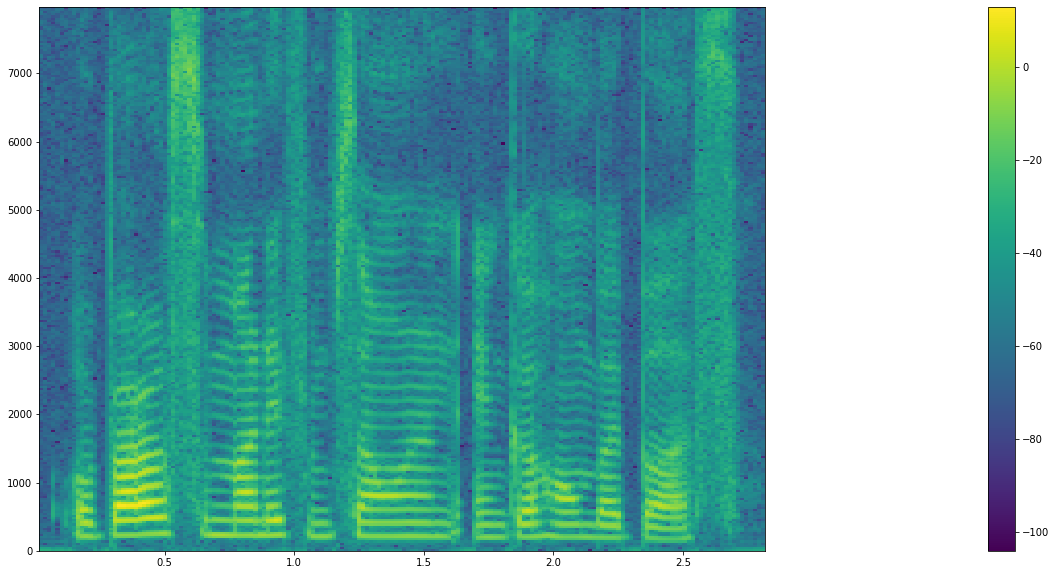

In [56]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, 16, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

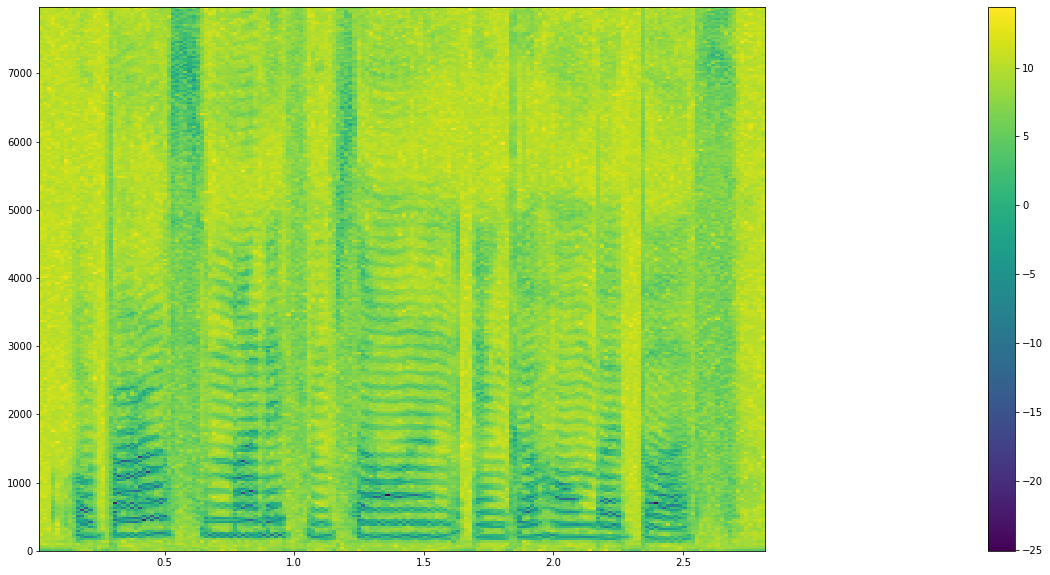

In [124]:
log_cep = np.log10(m_stft + np.finfo(np.float64).eps)
plot_spectrum(log_cep, v_freq, v_time)

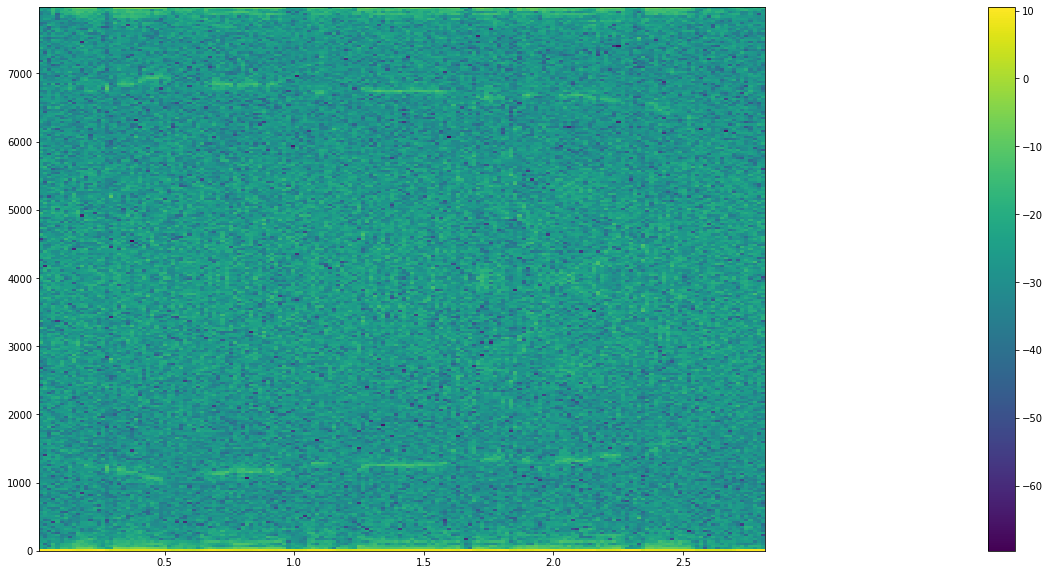

In [125]:
cep = np.fft.ifft(log_cep)
plot_spectrum(cep, v_freq, v_time)

In [190]:
selected_s = m_stft[52]
selected_cep = cep[52]

In [200]:
H_est, U_est = reconstruct_filter_and_source(selected_cep, sr, 1.)

In [201]:
S_db = 10 * np.log10(np.abs(selected_s))
H_est_db = 100 * np.log10(np.abs(H_est))

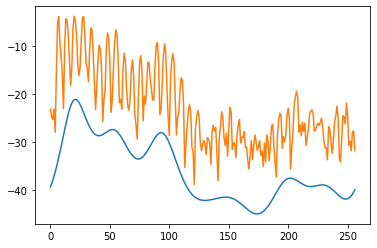

In [202]:
plt.plot(-H_est_db)
plt.plot(S_db)

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


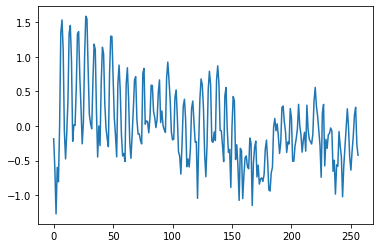

In [130]:
plt.plot(U_est)